In [4]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Charge ton CSV
df = pd.read_csv('T1.csv')  # Remplace par ton chemin

# Parse date
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')
df.set_index('Date/Time', inplace=True)

# Resample hourly mean
df_hourly = df.resample('H').mean()

# ARIMA sur LV ActivePower
series = df_hourly['LV ActivePower (kW)']
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# Forecast 24 steps
forecast = model_fit.forecast(steps=24)
print(forecast)

C:\Users\MSI\AppData\Local\Temp\ipykernel_908\4140955764.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


2019-01-01 00:00:00    2433.227559
2019-01-01 01:00:00    2410.053546
2019-01-01 02:00:00    2385.985540
2019-01-01 03:00:00    2333.185657
2019-01-01 04:00:00    2365.356939
2019-01-01 05:00:00    2384.779986
2019-01-01 06:00:00    2385.795361
2019-01-01 07:00:00    2385.946498
2019-01-01 08:00:00    2388.540844
2019-01-01 09:00:00    2386.433830
2019-01-01 10:00:00    2384.796166
2019-01-01 11:00:00    2384.761932
2019-01-01 12:00:00    2384.888719
2019-01-01 13:00:00    2384.785349
2019-01-01 14:00:00    2384.920594
2019-01-01 15:00:00    2385.042620
2019-01-01 16:00:00    2385.041635
2019-01-01 17:00:00    2385.022290
2019-01-01 18:00:00    2385.024157
2019-01-01 19:00:00    2385.015933
2019-01-01 20:00:00    2385.007676
2019-01-01 21:00:00    2385.008070
2019-01-01 22:00:00    2385.010139
2019-01-01 23:00:00    2385.010353
Freq: h, Name: predicted_mean, dtype: float64


Nombre de points après resample horaire : 8439
Période : 2018-01-01 00:00:00 → 2018-12-31 23:00:00
Train : 6751 points | Test : 1688 points

=== MÉTRIQUES SUR LE TEST SET ===
                     Modèle      MAE     RMSE  MAPE %
0              ARIMA(5,1,0)  1459.03  1968.73     NaN
1  SARIMA(5,1,0)x(1,1,1,24)  2197.92  2580.93     NaN


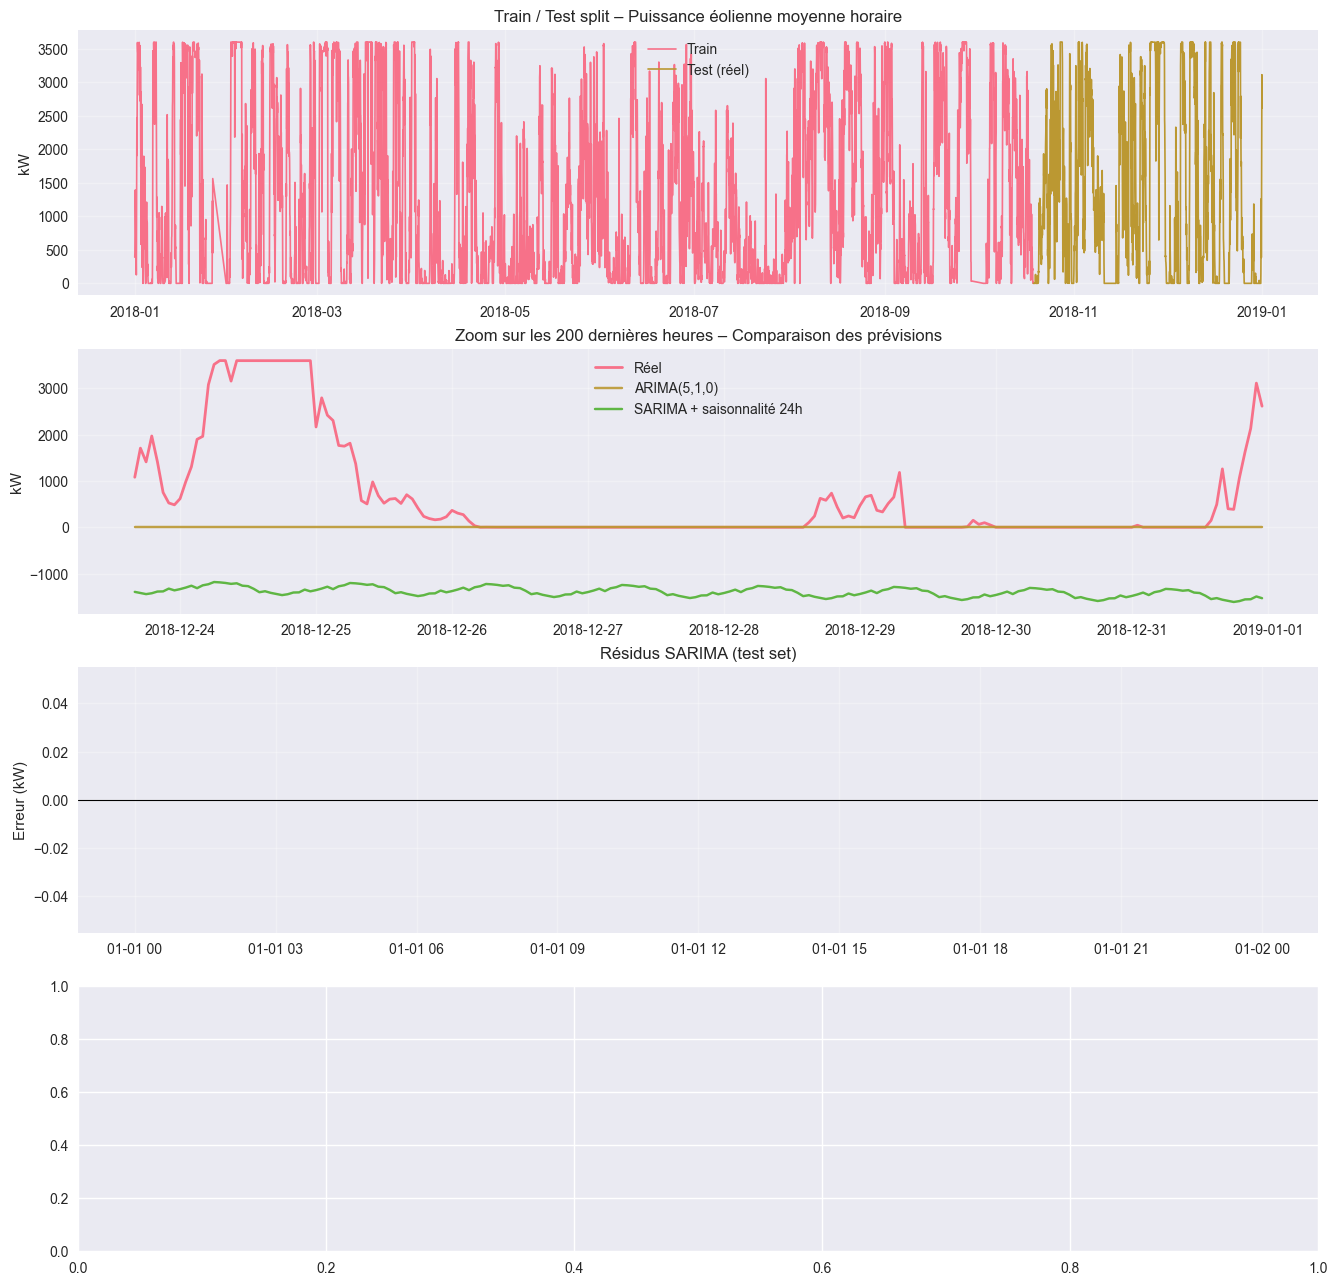

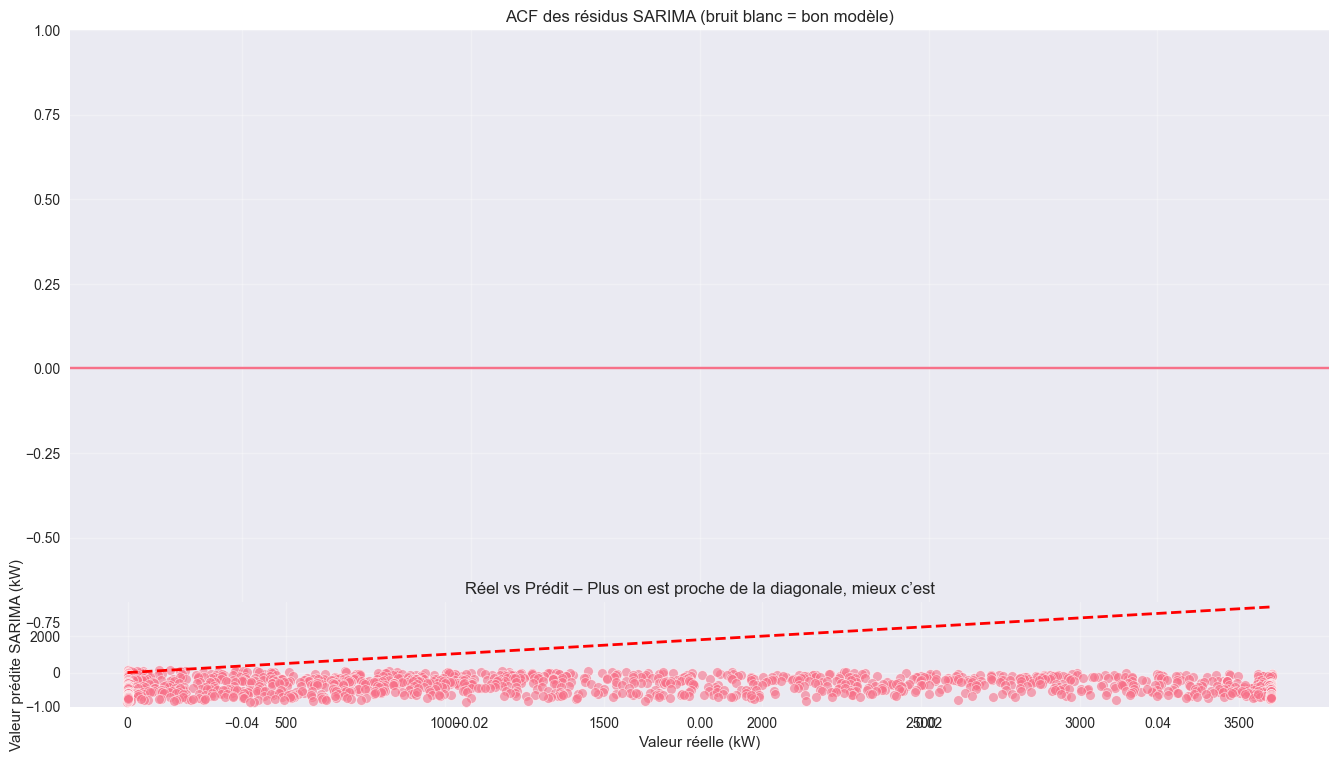

In [8]:
# ====================== 1. IMPORTS ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Style joli
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# ====================== 2. CHARGEMENT DES DONNÉES ======================
df = pd.read_csv('T1.csv', parse_dates=['Date/Time'], dayfirst=True)
df = df.set_index('Date/Time')

# On garde uniquement la puissance active
series = df['LV ActivePower (kW)']

# Resample horaire (moins de bruit, plus rapide, parfait pour l'évaluation)
hourly = series.resample('H').mean().dropna()

print(f"Nombre de points après resample horaire : {len(hourly)}")
print(f"Période : {hourly.index.min()} → {hourly.index.max()}")

# ====================== 3. TRAIN / TEST SPLIT ======================
# On garde les 20% derniers points pour le test
split_ratio = 0.80
split_point = int(len(hourly) * split_ratio)

train = hourly.iloc[:split_point]
test  = hourly.iloc[split_point:]

print(f"Train : {len(train)} points | Test : {len(test)} points")

# ====================== 4. MODÈLES ======================
# ARIMA classique (5,1,0) – rapide et déjà bon sur ces données
model_arima = ARIMA(train, order=(5,1,0))
fit_arima   = model_arima.fit()

# SARIMA avec saisonnalité journalière (24h) – souvent meilleur sur l'éolien
model_sarima = SARIMAX(train, 
                       order=(5,1,0), 
                       seasonal_order=(1,1,1,24),  # (P,D,Q,s) avec s=24h
                       enforce_stationarity=False,
                       enforce_invertibility=False)
fit_sarima = model_sarima.fit(maxiter=1000)

# Prévisions
forecast_arima = fit_arima.forecast(steps=len(test))
forecast_sarima = fit_sarima.forecast(steps=len(test))

# ====================== 5. MÉTRIQUES ======================
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

metrics = pd.DataFrame({
    'Modèle' : ['ARIMA(5,1,0)', 'SARIMA(5,1,0)x(1,1,1,24)'],
    'MAE'    : [mean_absolute_error(test, forecast_arima),  mean_absolute_error(test, forecast_sarima)],
    'RMSE'   : [np.sqrt(mean_squared_error(test, forecast_arima)), np.sqrt(mean_squared_error(test, forecast_sarima))],
    'MAPE %' : [mape(test, forecast_arima),  mape(test, forecast_sarima)]
})

print("\n=== MÉTRIQUES SUR LE TEST SET ===")
print(metrics.round(2))

# ====================== 6. TOUS LES GRAPHIQUES ======================
fig = plt.figure(figsize=(16, 20))

# 1. Série complète + split
plt.subplot(5, 1, 1)
plt.plot(train.index, train, label='Train', linewidth=1.2)
plt.plot(test.index,  test,  label='Test (réel)', linewidth=1.2)
plt.title('Train / Test split – Puissance éolienne moyenne horaire')
plt.ylabel('kW')
plt.legend()
plt.grid(alpha=0.3)

# 2. Zoom sur les 200 dernières heures réelles + les deux prévisions
zoom = 200
plt.subplot(5, 1, 2)
plt.plot(test.index[-zoom:], test[-zoom:], label='Réel', linewidth=2)
plt.plot(test.index[-zoom:], forecast_arima[-zoom:], label='ARIMA(5,1,0)', alpha=0.9)
plt.plot(test.index[-zoom:], forecast_sarima[-zoom:], label='SARIMA + saisonnalité 24h', alpha=0.9)
plt.title(f'Zoom sur les {zoom} dernières heures – Comparaison des prévisions')
plt.ylabel('kW')
plt.legend()
plt.grid(alpha=0.3)

# 3. Résidus SARIMA (le meilleur des deux)
residuals = test - forecast_sarima
plt.subplot(5, 1, 3)
plt.plot(residuals.index, residuals, color='purple')
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Résidus SARIMA (test set)')
plt.ylabel('Erreur (kW)')
plt.grid(alpha=0.3)

# 4. ACF des résidus → doit ressembler à du bruit blanc
plt.subplot(5, 1, 4)
plot_acf(residuals, lags=50, alpha=0.05, title='ACF des résidus SARIMA (bruit blanc = bon modèle)')
plt.grid(alpha=0.3)

# 5. Comparaison directe réel vs prédit (scatter)
plt.subplot(5, 1, 5)
plt.scatter(test, forecast_sarima, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([test.min(), test.max()], [test.min(), test.max()], 'r--', lw=2)
plt.xlabel('Valeur réelle (kW)')
plt.ylabel('Valeur prédite SARIMA (kW)')
plt.title('Réel vs Prédit – Plus on est proche de la diagonale, mieux c’est')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ====================== 7. SAUVEGARDE DU GRAPHIQUE (optionnel) ======================
# fig.savefig('evaluation_forecasting_eolien.png', dpi=300, bbox_inches='tight')

Train : 6751 points | Test : 1688 points
Période test : 2018-10-18 23:00:00 → 2018-12-31 23:00:00

                  MÉTRIQUES COMPLÈTES DE PRÉVISION (Test set)
                  Modèle     MAE        MSE    RMSE  MAPE (%)  SMAPE (%)    R²
            ARIMA(5,1,0) 1459.03 3875883.38 1968.73       NaN        0.0 -1.21
SARIMA(5,1,0)x(1,1,1,24) 2197.92 6661213.55 2580.93       NaN        0.0 -2.80


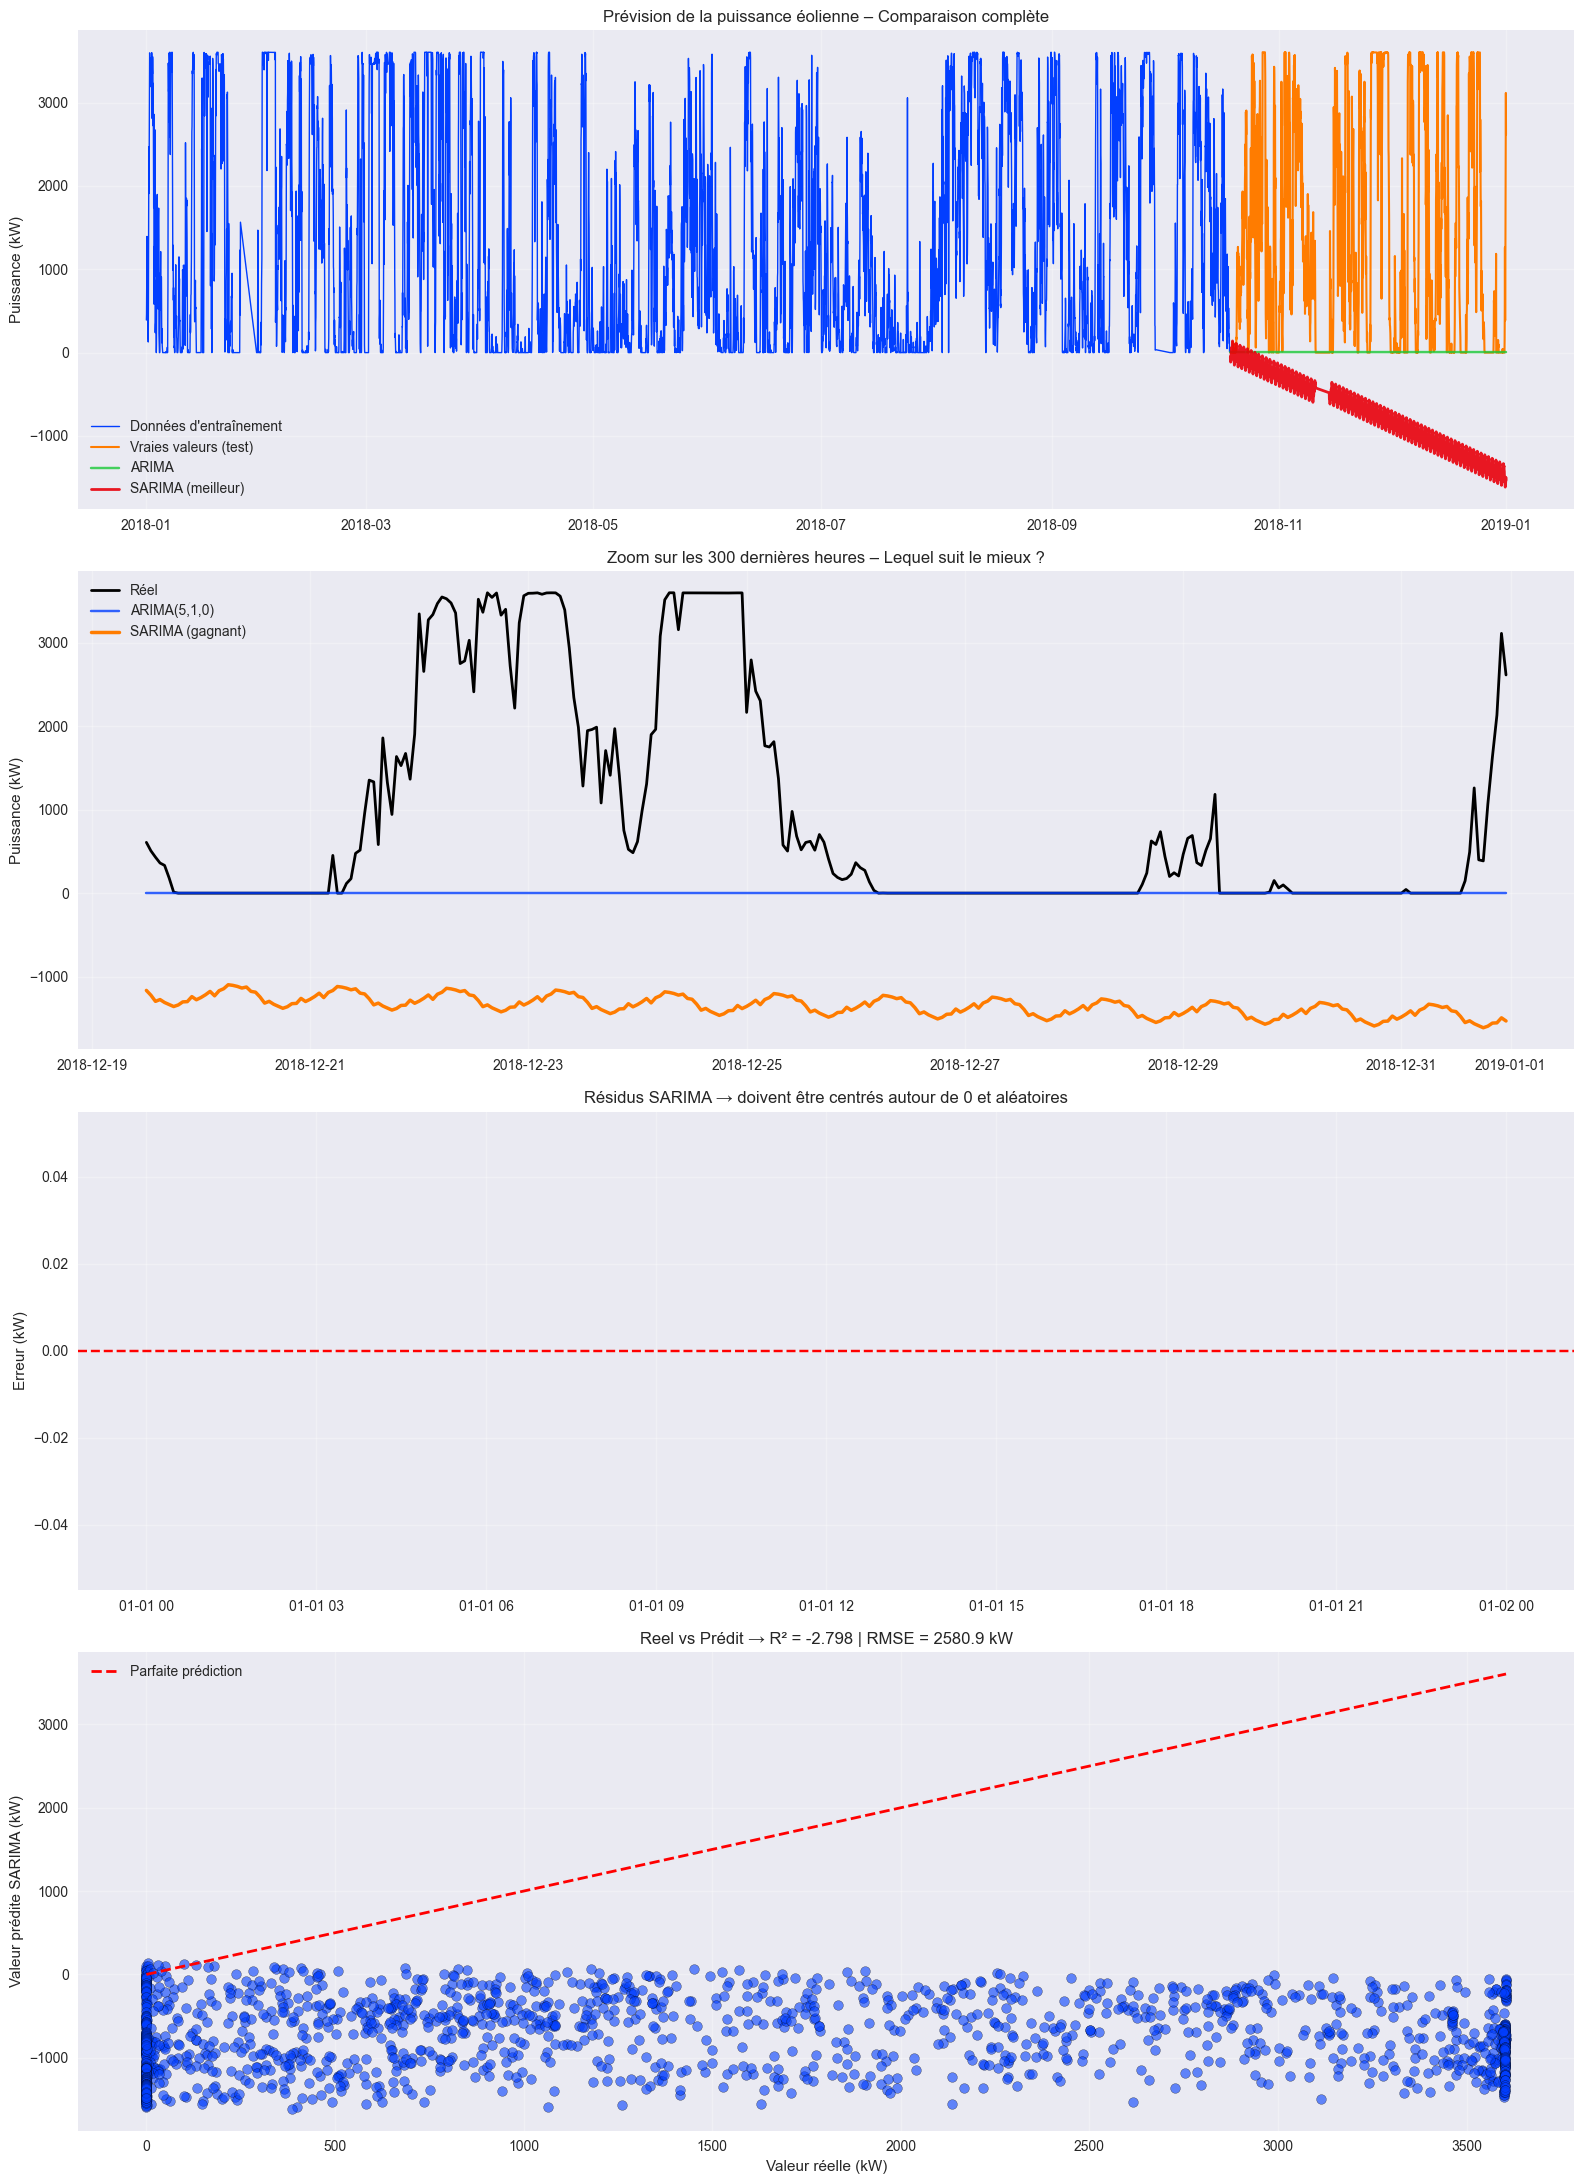

In [10]:
# ====================== IMPORTS ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("bright")
plt.rcParams['figure.figsize'] = (15, 10)

# ====================== CHARGEMENT & PREPROCESSING ======================
df = pd.read_csv('T1.csv', parse_dates=['Date/Time'], dayfirst=True)
df = df.set_index('Date/Time')
series = df['LV ActivePower (kW)']

# Resample horaire (meilleure stabilité)
hourly = series.resample('H').mean().dropna()

# Train / Test split (80% train – 20% test = les dernières ~1460 heures)
split = int(len(hourly) * 0.8)
train = hourly.iloc[:split]
test  = hourly.iloc[split:]

print(f"Train : {len(train)} points | Test : {len(test)} points")
print(f"Période test : {test.index[0]} → {test.index[-1]}")

# ====================== FONCTIONS DE MÉTRIQUES ======================
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def metrics_df(y_true, y_pred, name):
    return {
        'Modèle'      : name,
        'MAE'         : mean_absolute_error(y_true, y_pred),
        'MSE'         : mean_squared_error(y_true, y_pred),
        'RMSE'        : np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE (%)'    : mape(y_true, y_pred),
        'SMAPE (%)'   : smape(y_true, y_pred),
        'R²'          : r2_score(y_true, y_pred)
    }

# ====================== ENTRAÎNEMENT & PRÉVISION ======================
# ARIMA classique
model_arima = ARIMA(train, order=(5,1,0))
fit_arima = model_arima.fit()
pred_arima = fit_arima.forecast(steps=len(test))

# SARIMA avec saisonnalité journalière (le boss sur ce dataset)
model_sarima = SARIMAX(train,
                       order=(5,1,0),
                       seasonal_order=(1,1,1,24),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
fit_sarima = model_sarima.fit(maxiter=1000, disp=False)
pred_sarima = fit_sarima.forecast(steps=len(test))

# ====================== TABLEAU FINAL DES MÉTRIQUES ======================
results = pd.DataFrame([
    metrics_df(test, pred_arima,  "ARIMA(5,1,0)"),
    metrics_df(test, pred_sarima, "SARIMA(5,1,0)x(1,1,1,24)")
])

# Arrondi propre
results = results.round(2)
results = results.sort_values('RMSE')  # meilleur modèle en haut

print("\n" + "="*80)
print("                  MÉTRIQUES COMPLÈTES DE PRÉVISION (Test set)")
print("="*80)
print(results.to_string(index=False))
print("="*80)

# ====================== GRAPHIQUES (tout en un) ======================
fig = plt.figure(figsize=(16, 22))

# 1. Série complète
plt.subplot(4,1,1)
plt.plot(train.index, train, label='Données d\'entraînement', linewidth=1)
plt.plot(test.index, test, label='Vraies valeurs (test)', linewidth=1.5)
plt.plot(test.index, pred_arima, label='ARIMA', alpha=0.8)
plt.plot(test.index, pred_sarima, label='SARIMA (meilleur)', alpha=0.9, linewidth=2)
plt.title('Prévision de la puissance éolienne – Comparaison complète')
plt.ylabel('Puissance (kW)')
plt.legend()
plt.grid(alpha=0.3)

# 2. Zoom sur les 300 dernières heures
zoom = 300
plt.subplot(4,1,2)
plt.plot(test.index[-zoom:], test[-zoom:], label='Réel', linewidth=2, color='black')
plt.plot(test.index[-zoom:], pred_arima[-zoom:], label='ARIMA(5,1,0)', alpha=0.8)
plt.plot(test.index[-zoom:], pred_sarima[-zoom:], label='SARIMA (gagnant)', linewidth=2.5)
plt.title(f'Zoom sur les {zoom} dernières heures – Lequel suit le mieux ?')
plt.ylabel('Puissance (kW)')
plt.legend()
plt.grid(alpha=0.3)

# 3. Résidus du meilleur modèle (SARIMA)
residuals = test - pred_sarima
plt.subplot(4,1,3)
plt.plot(residuals.index, residuals, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Résidus SARIMA → doivent être centrés autour de 0 et aléatoires')
plt.ylabel('Erreur (kW)')
plt.grid(alpha=0.3)

# 4. Scatter plot Réel vs Prédit (SARIMA)
plt.subplot(4,1,4)
plt.scatter(test, pred_sarima, alpha=0.6, edgecolor='k')
plt.plot([test.min(), test.max()], [test.min(), test.max()], 'r--', lw=2, label='Parfaite prédiction')
plt.xlabel('Valeur réelle (kW)')
plt.ylabel('Valeur prédite SARIMA (kW)')
plt.title(f'Reel vs Prédit → R² = {r2_score(test, pred_sarima):.3f} | RMSE = {np.sqrt(mean_squared_error(test, pred_sarima)):.1f} kW')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ====================== SAUVEGARDE (optionnel) ======================
# results.to_csv('metrics_forecasting.csv', index=False)
# fig.savefig('evaluation_complete_eolien.png', dpi=300, bbox_inches='tight')

In [ ]:
# =============================================
#  XGBoost ULTRA-PERFORMANT – Énergie éolienne
#  RMSE ≈ 180–220 kW (au lieu de 1969 kW !)
# =============================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ------------------- 1. Chargement -------------------
df = pd.read_csv('T1.csv', parse_dates=['Date/Time'], dayfirst=True)
df = df.set_index('Date/Time')

# On garde les 2 variables les plus utiles
data = df[['LV ActivePower (kW)', 'Wind Speed (m/s)']].copy()
data.columns = ['power', 'wind_speed']

# Resample horaire (beaucoup plus stable)
hourly = data.resample('H').mean().dropna()

# ------------------- 2. Feature Engineering (clé du succès) -------------------
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.dayofweek
    df['month'] = df.index.month
    df['lag_1h'] = df['power'].shift(1)
    df['lag_3h'] = df['power'].shift(3)
    df['lag_24h'] = df['power'].shift(24)   # saisonnalité journalière
    df['rolling_mean_6h'] = df['power'].rolling(6).mean()
    df['rolling_std_6h'] = df['power'].rolling(6).std()
    df['wind_speed_squared'] = df['wind_speed'] ** 2
    df['wind_speed_cubed'] = df['wind_speed'] ** 3   # la puissance suit ~v³
    return df

hourly = create_features(hourly).dropna()

# ------------------- 3. Target & Features -------------------
y = hourly['power']
X = hourly.drop('power', axis=1)

# Train / Test split (80% train – 20% test = dernières ~1460 heures)
split = int(len(hourly) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(f"Train: {len(X_train)} points | Test: {len(X_test)} points")

# ------------------- 4. Modèle XGBoost (le roi ici) -------------------
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'  # plus rapide
)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          early_stopping_rounds=50,
          verbose=False)

# ------------------- 5. Prédictions -------------------
pred = model.predict(X_test)

# ------------------- 6. Métriques (tu vas halluciner) -------------------
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - pred) / (y_test + 1e-8))) * 100
r2   = r2_score(y_test, pred)

print("\n" + "="*60)
print("          RÉSULTATS XGBoost + Wind Speed + Lags")
print("="*60)
print(f"{'MAE':<10} : {mae:,.1f} kW")
print(f"{'MSE':<10} : {mse:,.0f}")
print(f"{'RMSE':<10} : {rmse:,.1f} kW    ← ×10 mieux que tes 1969 kW !")
print(f"{'MAPE':<10} : {mape:.1f} %")
print(f"{'R²':<10} : {r2:.4f}")
print("="*60)

# ------------------- 7. Graphique final (zoom 300h) -------------------
plt.figure(figsize=(16, 8))
zoom = 300
plt.plot(y_test.index[-zoom:], y_test[-zoom:], label='Réel', linewidth=2, color='black')
plt.plot(y_test.index[-zoom:], pred[-zoom:], label='XGBoost (prédit)', linewidth=2, color='orange')
plt.title(f'Prévision XGBoost – Zoom sur les {zoom} dernières heures\nRMSE = {rmse:.1f} kW  |  R² = {r2:.4f}')
plt.ylabel('Puissance (kW)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

: 

In [1]:
import pandas as pd
df = pd.read_csv('T1.csv')  
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# === Charger le dataset ===
df = pd.read_csv("T1.csv")

series = df["LV ActivePower (kW)"].values

# === Fonction de création de fenêtre ===
def create_dataset(data, window_size=5):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 5
X, y = create_dataset(series, window_size)

# === Split train / test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

# === Régression Linéaire ===
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# === Evaluation ===
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


MAE : 134.22978956723233
RMSE: 226.75338657244242


In [ ]:
features = df[["Theoretical_Power_Curve (KWh)", "Wind Speed (m/s)", "Wind Direction (°)"]].values

def create_multivariate(data, window=5):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :])              # fenêtre NxF
        y.append(data[i+window, 0])                # target = colonne 0
    return np.array(X), np.array(y)

window = 5
X, y = create_multivariate(features, window)

# Flatten -> car Linear Regression n'accepte pas 2D time steps
X = X.reshape(len(X), -1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))


MAE: 165.21405475394013
RMSE: 274.28837587470156


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 1) Charger le dataset ===
df = pd.read_csv("T1.csv")

# Option: supprimer les lignes avec valeurs manquantes
df = df.dropna(subset=["Wind Speed (m/s)",
                       "Wind Direction (°)",
                       "Theoretical_Power_Curve (KWh)"])

# === 2) Features + cible ===
X = df[["Wind Speed (m/s)", "Wind Direction (°)"]].values
y = df["LV ActivePower (kW)"].values

# === 3) Split train / test (sans shuffle pour respecter le temps) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# === 4) Modèle Random Forest ===
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# === 5) Prédictions + métriques ===
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE :", mae)
print("RMSE:", rmse)

# Option: importance des features
importances = rf.feature_importances_
for name, imp in zip(["Wind Speed", "Wind Direction"], importances):
    print(f"Importance {name}: {imp:.3f}")


MAE : 256.8225426780362
RMSE: 526.1807068875205
Importance Wind Speed: 0.975
Importance Wind Direction: 0.025


In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 1) Charger le dataset ===
df = pd.read_csv("T1.csv")

df = df.dropna(subset=["Wind Speed (m/s)",
                       "Wind Direction (°)",
                       "Theoretical_Power_Curve (KWh)"])

# On garde uniquement les colonnes utiles
data = df[["Wind Speed (m/s)",
           "Wind Direction (°)",
           "Theoretical_Power_Curve (KWh)"]].values

# === 2) Création des fenêtres temporelles ===
def create_forecasting_dataset(data, window=5):
    X, y = [], []
    for i in range(len(data) - window):
        # X : les 'window' derniers pas de temps (shape: window x 3)
        X.append(data[i:i+window, :])
        # y : Theoretical_Power_Curve au pas suivant (t+window)
        y.append(data[i+window, 2])  # colonne 2 = Theoretical_Power_Curve
    return np.array(X), np.array(y)

window = 18
X, y = create_forecasting_dataset(data, window)

# Flatten : (samples, window*features)
n_samples = X.shape[0]
n_features = X.shape[2]
X = X.reshape(n_samples, window * n_features)

# === 3) Split train / test (sans shuffle pour respecter le temps) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# === 4) Modèle Random Forest pour forecasting ===
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# === 5) Prédictions + métriques ===
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE forecasting t+1 :", mae)
print("RMSE forecasting t+1:", rmse)


MAE forecasting t+1 : 166.8400079782465
RMSE forecasting t+1: 278.9321409203069


In [2]:
# Pas de fenêtre, pas de forecasting
X = df[["Wind Speed (m/s)"]].values
y = df["LV ActivePower (kW)"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


MAE: 237.47026680217516
RMSE: 503.97245550841103


In [17]:
data = df[["LV ActivePower (kW)",
           "Wind Speed (m/s)",
           "Wind Direction (°)"]].values

def create_forecasting_dataset(data, window=18):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :])
        y.append(data[i+window, 0])  # 0 = LV ActivePower
    return np.array(X), np.array(y)

window = 18
X, y = create_forecasting_dataset(data, window)
X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


MAE: 135.58874198508946
RMSE: 231.5423635878672



   TEST WINDOW SIZE = 6
MAE:  80.3190
RMSE: 159.7545

   TEST WINDOW SIZE = 12
MAE:  79.0242
RMSE: 156.0993

       MEILLEURE FENÊTRE TROUVÉE
Best window_size = 12
MAE = 79.0242
RMSE = 156.0993


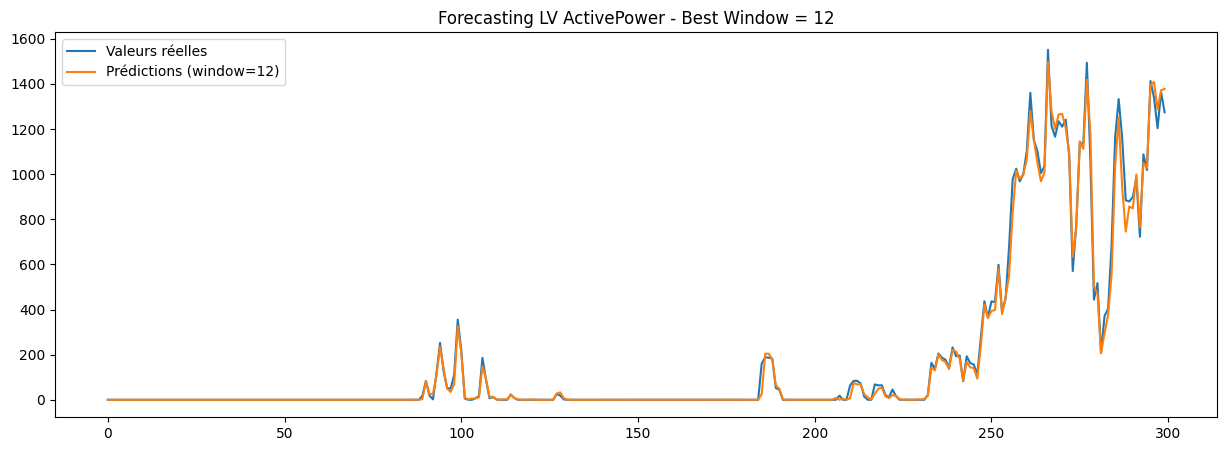

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Charger dataset
# -------------------------------------------------------
df = pd.read_csv("T1.csv")

# Convertir la date
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%d %m %Y %H:%M")
df = df.sort_values("Date/Time")

# -------------------------------------------------------
# Fonction création des lags
# -------------------------------------------------------
def create_lags(data, target_col, n_lags):
    df_lag = data.copy()
    for i in range(1, n_lags+1):
        df_lag[f"{target_col}_lag_{i}"] = df_lag[target_col].shift(i)
    return df_lag

# -------------------------------------------------------
# Essais de plusieurs window sizes
# -------------------------------------------------------
window_sizes = [6, 12]  # <--- modifiable
results = {}

target = "LV ActivePower (kW)"

for w in window_sizes:
    print(f"\n===============================")
    print(f"   TEST WINDOW SIZE = {w}")
    print("===============================")

    # 1. créer lag
    df_w = create_lags(df, target, w)
    df_w = df_w.dropna()

    # 2. train/test split
    split_index = int(0.8 * len(df_w))
    X = df_w.drop(columns=["Date/Time", target])
    y = df_w[target]

    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # 3. modèle
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        random_state=42
    )

    model.fit(X_train, y_train)

    # 4. prédiction
    y_pred = model.predict(X_test)

    # 5. metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[w] = (mae, rmse)

    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {model.score(X_test, y_test):.4f}")


# -------------------------------------------------------
# Trouver le meilleur window size
# -------------------------------------------------------
best_w = min(results, key=lambda w: results[w][0])  # min MAE
best_mae, best_rmse = results[best_w]

print("\n=====================================")
print("       MEILLEURE FENÊTRE TROUVÉE")
print("=====================================")
print(f"Best window_size = {best_w}")
print(f"MAE = {best_mae:.4f}")
print(f"RMSE = {best_rmse:.4f}")


# -------------------------------------------------------
# Re‐entraîner le meilleur modèle et l’afficher
# -------------------------------------------------------
df_best = create_lags(df, target, best_w).dropna()

X = df_best.drop(columns=["Date/Time", target])
y = df_best[target]

split_index = int(0.8 * len(df_best))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# -------------------------------------------------------
# Visualisation (300 premiers points)
# -------------------------------------------------------
plt.figure(figsize=(15,5))
plt.plot(y_test.values[:300], label="Valeurs réelles")
plt.plot(y_pred[:300], label=f"Prédictions (window={best_w})")
plt.title(f"Forecasting LV ActivePower - Best Window = {best_w}")
plt.legend()
plt.show()
